<a href="https://colab.research.google.com/github/fhzh123/CAU_mAI/blob/main/Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation

## 독일어->영어 기계번역

### 1. 라이브러리 불러오기

In [1]:
!pip install torchtext==0.6.0 --quiet
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import numpy as np
import pandas as pd
import spacy
import random
from torchtext.data.metrics import bleu_score
from pprint import pprint
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

SEED = 777

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.4 MB/s eta 0:00:00


### 2. 데이터 준비 및 전처리

spaCy는 자연어 처리를 위한 Python 기반의 오픈 소스 라이브러리

In [2]:
!python -m spacy download en_core_web_sm --quiet
!python -m spacy download de_core_news_sm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 60.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


spacy에서 제공하는 독일어 및 영어 토크나이저를 활용하도록 하겠습니다.

In [3]:
spacy_german = spacy.load("de_core_news_sm")
spacy_english = spacy.load("en_core_web_sm")

In [4]:
def tokenize_german(text):
  return [token.text for token in spacy_german.tokenizer(text)]

def tokenize_english(text):
  return [token.text for token in spacy_english.tokenizer(text)]

### Sample Run ###

sample_text = "I love machine learning"
print(tokenize_english(sample_text))

['I', 'love', 'machine', 'learning']


데이터를 다운받도록 하겠습니다. 금번 실습에서 활용한 데이터는 WMT2016에서 활용된 영<->독 번역 관련 데이터셋입니다. 자세한 내용은 아래의 링크에서 확인할 수 있습니다.

https://www.statmt.org/wmt16/

In [5]:
!git clone --recursive https://github.com/multi30k/dataset.git multi30k-dataset

Cloning into 'multi30k-dataset'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 313 (delta 17), reused 21 (delta 16), pack-reused 281 (from 1)
Receiving objects: 100% (313/313), 18.21 MiB | 23.04 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Submodule 'scripts/subword-nmt' (https://github.com/rsennrich/subword-nmt.git) registered for path 'scripts/subword-nmt'
Cloning into '/content/multi30k-dataset/scripts/subword-nmt'...
remote: Enumerating objects: 622, done.        
remote: Counting objects: 100% (46/46), done.        
remote: Compressing objects: 100% (30/30), done.        
remote: Total 622 (delta 25), reused 31 (delta 16), pack-reused 576 (from 1)        
Receiving objects: 100% (622/622), 261.27 KiB | 7.46 MiB/s, done.
Resolving deltas: 100% (374/374), done.
Submodule path 'scripts/subword-nmt': checked out '80b7c1449e2e26673fb0b5cae993fe2d0dc23846'


In [6]:
!gzip -d multi30k-dataset/data/task1/raw/train.en.gz
!gzip -d multi30k-dataset/data/task1/raw/train.de.gz
!gzip -d multi30k-dataset/data/task1/raw/val.en.gz
!gzip -d multi30k-dataset/data/task1/raw/val.de.gz
!gzip -d multi30k-dataset/data/task1/raw/test_2016_flickr.en.gz
!gzip -d multi30k-dataset/data/task1/raw/test_2016_flickr.de.gz
!mv multi30k-dataset/data/task1/raw/test_2016_flickr.de multi30k-dataset/data/task1/raw/test2016.de
!mv multi30k-dataset/data/task1/raw/test_2016_flickr.en multi30k-dataset/data/task1/raw/test2016.en

#### Torchtext 활용

Torchtext는 다양한 NLP 작업에 사용할 텍스트 데이터를 만드는 강력한 라이브러리입니다. 텍스트 데이터에 대한 사전 처리를 수행하는 데 필요한 모든 도구가 있습니다.

* Train/Valid/Test 분할: 데이터를 지정된 세트로 분할합니다.
* 파일 로딩: 다양한 형식(.txt, .json, .csv등)의 텍스트 코퍼스를 불러옵니다.
* 토크나이징: 문장을 토크나이징합니다.
* vocab: 텍스트 코퍼스에서 어휘 목록을 생성합니다.
* Integer Mapper: 전체 코퍼스를 정수 단위로 매핑합니다. 그 반대도 실행할 수 있습니다.

이번 실습에서는 3가지 모듈을 활용해보겠습니다.
* Fields: torchtext의 고유한 클래스로 데이터 코퍼스의 전처리를 수행하는 방법을 지정합니다.
* TabularDataset: 이전 실습에서 배운 TensorDataset과 비슷합니다. Tabular형태로 되어있는 데이터들을 pytorch의 dataset클래스로 변환합니다.
* BucketIterator: TabularDataset에 대해서 패딩을 수행하고 배치단위로 수정합니다.

In [7]:
german = Field(tokenize=tokenize_german,
               lower=True,
               init_token="<sos>",
               eos_token="<eos>")

english = Field(tokenize=tokenize_english,
               lower=True,
               init_token="<sos>",
               eos_token="<eos>")

train_data, valid_data, test_data = Multi30k.splits(path = 'multi30k-dataset/data/task1/raw',
                                                    exts = (".de", ".en"),
                                                    fields=(german, english))

german.build_vocab(train_data, max_size=10000, min_freq=3)
english.build_vocab(train_data, max_size=10000, min_freq=3)

In [8]:
print(f"Unique tokens in source (de) vocabulary: {len(german.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(english.vocab)}")

Unique tokens in source (de) vocabulary: 5374
Unique tokens in target (en) vocabulary: 4556


In [9]:
# dir(english.vocab)

print(english.vocab.__dict__.keys())
print(list(english.vocab.__dict__.values()))

dict_keys(['freqs', 'itos', 'unk_index', 'stoi', 'vectors'])
[Counter({'a': 49165, '.': 27623, 'in': 14886, 'the': 10955, 'on': 8035, 'man': 7781, 'is': 7525, 'and': 7379, 'of': 6871, 'with': 6179, 'woman': 3973, ',': 3963, 'two': 3886, 'are': 3717, 'to': 3128, 'people': 3122, 'at': 2927, 'an': 2861, 'wearing': 2623, 'shirt': 2324, 'young': 2280, 'white': 2238, 'black': 2019, 'his': 1969, 'while': 1947, 'blue': 1880, 'men': 1759, 'red': 1755, 'sitting': 1743, 'girl': 1723, 'boy': 1687, 'dog': 1675, 'standing': 1614, 'playing': 1584, 'group': 1553, 'street': 1449, 'down': 1404, 'walking': 1378, '-': 1345, 'front': 1274, 'her': 1263, 'holding': 1238, 'one': 1092, 'water': 1064, 'three': 1057, 'by': 1046, 'women': 988, 'up': 938, 'green': 926, 'little': 916, 'for': 906, 'child': 894, 'looking': 894, 'outside': 871, 'as': 851, 'large': 843, 'through': 813, 'brown': 795, 'yellow': 785, 'children': 768, 'person': 753, 'from': 728, 'their': 725, 'hat': 724, 'ball': 723, 'into': 711, 'small': 

In [10]:
e = list(english.vocab.__dict__.values())

word_2_idx = dict(e[3])
idx_2_word = {}
for k,v in word_2_idx.items():
  idx_2_word[v] = k

In [11]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(train_data[5].__dict__.keys())
pprint(train_data[5].__dict__.values())

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000
dict_keys(['src', 'trg'])
dict_values([['ein', 'mann', 'in', 'grün', 'hält', 'eine', 'gitarre', ',', 'während', 'der', 'andere', 'mann', 'sein', 'hemd', 'ansieht', '.'], ['a', 'man', 'in', 'green', 'holds', 'a', 'guitar', 'while', 'the', 'other', 'man', 'observes', 'his', 'shirt', '.']])


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data),
                                                                      batch_size = BATCH_SIZE,
                                                                      sort_within_batch=True,
                                                                      sort_key=lambda x: len(x.src),
                                                                      device = device)

In [13]:
count = 0
max_len_eng = []
max_len_ger = []
for data in train_data:
  max_len_ger.append(len(data.src))
  max_len_eng.append(len(data.trg))
  if count < 10 :
    print("German - ",*data.src, " Length - ", len(data.src))
    print("English - ",*data.trg, " Length - ", len(data.trg))
    print()
  count += 1

print("Maximum Length of English sentence {} and German sentence {} in the dataset".format(max(max_len_eng),max(max_len_ger)))
print("Minimum Length of English sentence {} and German sentence {} in the dataset".format(min(max_len_eng),min(max_len_ger)))

German -  zwei junge weiße männer sind im freien in der nähe vieler büsche .  Length -  13
English -  two young , white males are outside near many bushes .  Length -  11

German -  mehrere männer mit schutzhelmen bedienen ein antriebsradsystem .  Length -  8
English -  several men in hard hats are operating a giant pulley system .  Length -  12

German -  ein kleines mädchen klettert in ein spielhaus aus holz .  Length -  10
English -  a little girl climbing into a wooden playhouse .  Length -  9

German -  ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster .  Length -  15
English -  a man in a blue shirt is standing on a ladder cleaning a window .  Length -  15

German -  zwei männer stehen am herd und bereiten essen zu .  Length -  10
English -  two men are at the stove preparing food .  Length -  9

German -  ein mann in grün hält eine gitarre , während der andere mann sein hemd ansieht .  Length -  16
English -  a man in green holds a guitar while the other

In [14]:
count = 0
for data in train_iterator:
  if count < 1 :
    print("Shapes", data.src.shape, data.trg.shape)
    print()
    print("German - ",*data.src, " Length - ", len(data.src))
    print()
    print("English - ",*data.trg, " Length - ", len(data.trg))
    temp_ger = data.src
    temp_eng = data.trg
    count += 1

Shapes torch.Size([13, 32]) torch.Size([17, 32])

German -  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0') tensor([   5,   15,    5,    5,    8,    5,   43,    5,   15,    8,    5,   18,
           8, 3935,    8,    8,    8,   47,    5,    5,    8,    5,   18,    5,
           8,    8,    8,    8,   18,   35,    5,    8], device='cuda:0') tensor([  70,   26,   13,   13,   36,  171,   45, 1144,  103,  168,   70,   80,
         423,   11, 2797,   16,   16,    6,   13,   70,   26,   96,   45,   13,
         274,   36, 2655,  168,   65,   44,  654,   16], device='cuda:0') tensor([  26,  550,   12,   29,   22,   32,    7,  272,   32, 2249,   26,  466,
           0,  605,  323,   31,   37,  348,    7,  820,   16,   13,    7,   20,
          16,  371,    0,   36, 4041, 3613,   13,   62], device='cuda:0') tensor([   7, 1057,    6,   12,   45,   29,  648,   13,    0,   22,   12,    9,
          30, 5031,  466,   

In [15]:
temp_eng_idx = (temp_eng).cpu().detach().numpy()
temp_ger_idx = (temp_ger).cpu().detach().numpy()

In [16]:
df_eng_idx = pd.DataFrame(data = temp_eng_idx, columns = [str("S_")+str(x) for x in np.arange(1, 33)])
df_eng_idx.index.name = 'Time Steps'
df_eng_idx.index = df_eng_idx.index + 1
# df_eng_idx.to_csv('/content/idx.csv')
df_eng_idx

,S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9,S_10,...,S_23,S_24,S_25,S_26,S_27,S_28,S_29,S_30,S_31,S_32
Time Steps,,,,,,,,,,,,,,,,,,,,,
1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,4,7,4,9,4,7,176,145,7,4,...,16,4,4,4,4,4,16,226,4,4
3,53,24,9,10,38,61,17,683,70,59,...,50,9,122,38,166,381,196,4,26,14
4,34,224,8,36,12,35,48,9,35,448,...,6,6,14,12,200,12,17,188,9,10
5,6,105,4,8,50,89,50,13,0,12,...,204,4,22,123,137,905,1041,135,13,78
6,4,1128,264,25,617,6,6,4,7,233,...,2207,197,4,215,8,17,95,4,4,44
7,2167,69,10,211,6,7,90,441,59,19,...,533,3159,178,254,4,312,11,0,31,99
8,10,7,92,11,755,47,533,32,35,17,...,17,8,29,54,0,54,46,105,630,11
9,377,43,6,45,1411,11,36,40,6,32,...,239,4,314,7,149,4,10,10,10,304


In [17]:
df_eng_word = pd.DataFrame(columns = [str("S_")+str(x) for x in np.arange(1, 33)])
df_eng_word = df_eng_idx.replace(idx_2_word)
# df_eng_word.to_csv('/content/Words.csv')
df_eng_word

,S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9,S_10,...,S_23,S_24,S_25,S_26,S_27,S_28,S_29,S_30,S_31,S_32
Time Steps,,,,,,,,,,,,,,,,,,,,,
1,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,...,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>
2,a,the,a,man,a,the,there,old,the,a,...,two,a,a,a,a,a,two,during,a,a
3,little,young,man,is,group,brown,are,bald,small,large,...,women,man,blond,group,rock,lot,kids,a,black,woman
4,boy,basketball,on,standing,of,dog,three,man,dog,number,...,in,in,woman,of,band,of,are,baseball,man,is
5,in,player,a,on,women,stands,women,with,<unk>,of,...,purple,a,wearing,soccer,plays,bicyclists,shoveling,game,with,riding
6,a,moves,skateboard,white,competing,in,in,a,the,elderly,...,shiny,suit,a,players,on,are,snow,a,a,her
7,kilt,into,is,sand,in,the,pink,beard,large,people,...,dresses,reclines,dark,waiting,a,ready,and,<unk>,red,bike
8,is,the,jumping,and,roller,water,dresses,sitting,dog,are,...,are,on,blue,for,<unk>,for,one,player,mask,and
9,fishing,front,in,holding,derby,and,standing,down,in,sitting,...,dancing,a,tank,the,stage,a,is,is,is,enjoying


### 3. Encoder 모델 구조

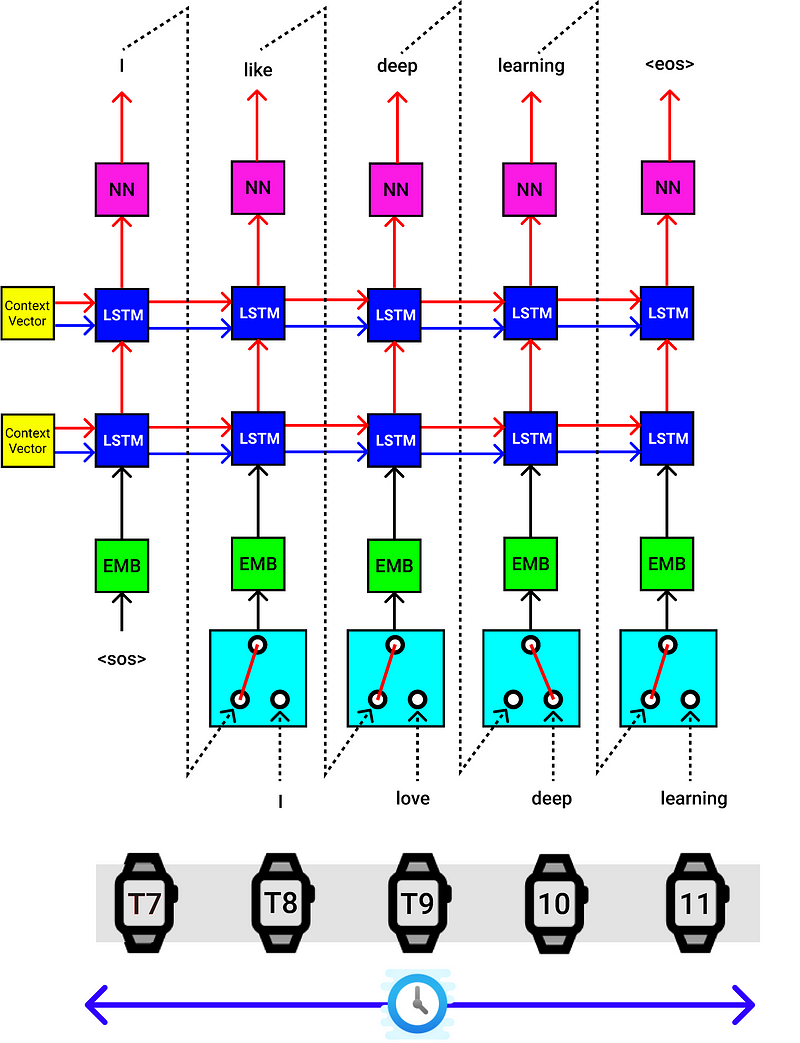

In [18]:
class EncoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super(EncoderLSTM, self).__init__()

    # 인코더에 입력으로 들어가는 원핫 벡터의 크기
    self.input_size = input_size

    # 단어 임베딩 신경망의 출력 크기
    self.embedding_size = embedding_size

    # LSTM 셀 내부의 뉴런 크기 / (hidden state, cell state)의 차원
    self.hidden_size = hidden_size

    # LSTM 레이어의 개수
    self.num_layers = num_layers

    # 드롭아웃 비율 (정규화 파라미터)
    self.dropout = nn.Dropout(p)
    self.tag = True

    # 임베딩 레이어: 입력 크기와 임베딩 차원을 정의 (형태: (5376, 300))
    self.embedding = nn.Embedding(input_size, embedding_size)

    # LSTM 레이어: 입력 임베딩 차원, hidden state 크기, 레이어 수, 드롭아웃 설정 (형태: (300, 2, 1024))
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)

  # x의 형태: (26, 32) [시퀀스 길이, 배치 크기]
  def forward(self, x):

    # 임베딩 레이어를 통과한 결과 형태: (26, 32, 300) [시퀀스 길이, 배치 크기, 임베딩 차원]
    embedding = self.dropout(self.embedding(x))

    # LSTM 출력 형태:
    # outputs: (26, 32, 1024) [시퀀스 길이, 배치 크기, hidden state 차원]
    # hidden_state와 cell_state: 각각 (2, 32, 1024) [레이어 수, 배치 크기, hidden state 차원]
    outputs, (hidden_state, cell_state) = self.LSTM(embedding)

    return hidden_state, cell_state

input_size_encoder = len(german.vocab)  # 인코더 입력 크기: 독일어 어휘의 크기
encoder_embedding_size = 300  # 임베딩 벡터의 차원
hidden_size = 1024  # LSTM hidden state의 차원
num_layers = 2  # LSTM 레이어 수
encoder_dropout = 0.5  # 드롭아웃 비율

encoder_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size,
                           hidden_size, num_layers, encoder_dropout).to(device)
print(encoder_lstm)

EncoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(5374, 300)
  (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
)


### 4. Decoder 모델 구조

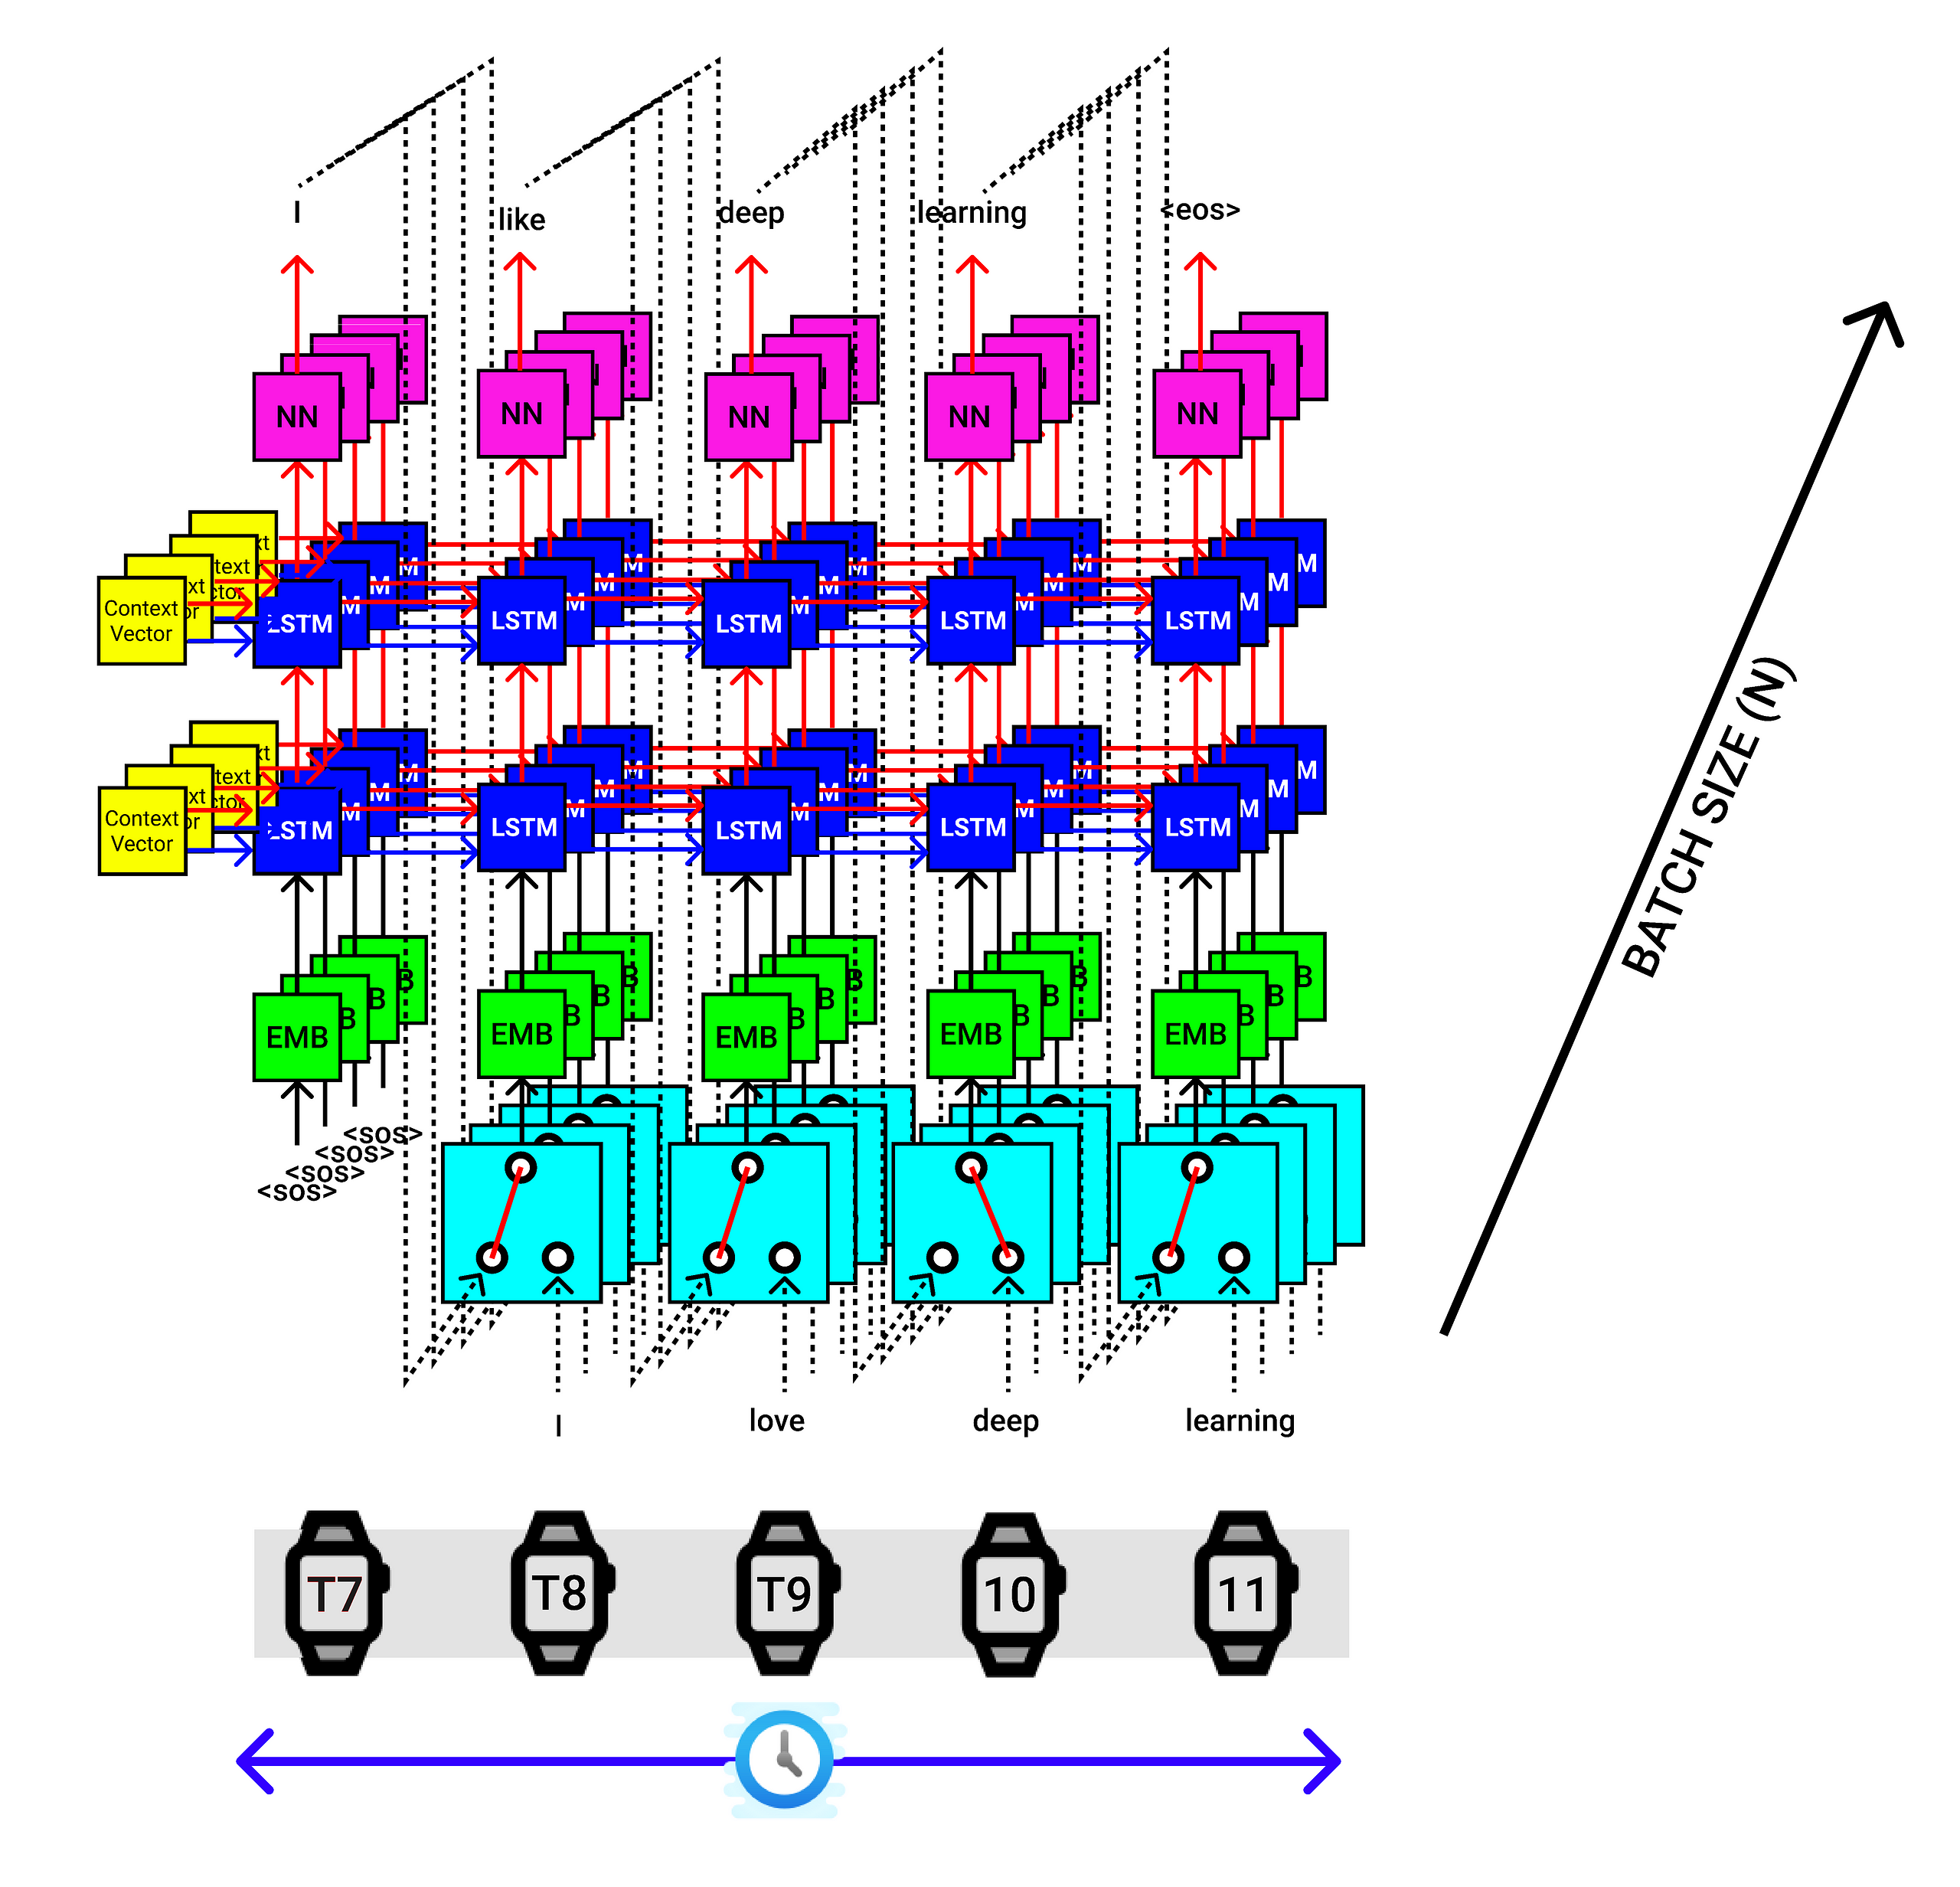

In [19]:
class DecoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, output_size):
    super(DecoderLSTM, self).__init__()

    # 디코더에 입력으로 들어가는 원핫 벡터의 크기
    #self.input_size = input_size

    # 단어 임베딩 신경망의 출력 크기
    #self.embedding_size = embedding_size

    # LSTM 셀 내부의 뉴런 크기 / (hidden state, cell state)의 차원
    self.hidden_size = hidden_size

    # LSTM 레이어의 개수
    self.num_layers = num_layers

    # 디코더의 출력으로 나오는 원핫 벡터의 크기 (영어 어휘 크기)
    self.output_size = output_size

    # 드롭아웃 비율 (정규화 파라미터)
    self.dropout = nn.Dropout(p)

    # 임베딩 레이어: 입력 크기와 임베딩 차원을 정의 (형태: (5376, 300))
    self.embedding = nn.Embedding(input_size, embedding_size)

    # LSTM 레이어: 입력 임베딩 차원, hidden state 크기, 레이어 수, 드롭아웃 설정 (형태: (300, 2, 1024))
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)

    # 완전 연결 레이어: hidden state 크기를 출력 크기로 변환 (형태: (1024, 4556))
    self.fc = nn.Linear(hidden_size, output_size)

  # x의 형태: (32) [배치 크기]
  def forward(self, x, hidden_state, cell_state):

    # x의 형태를 변경: (1, 32) [1, 배치 크기]
    x = x.unsqueeze(0)

    # 임베딩 레이어를 통과한 결과 형태: (1, 32, 300) [1, 배치 크기, 임베딩 차원]
    embedding = self.dropout(self.embedding(x))

    # LSTM 출력 형태:
    # outputs: (1, 32, 1024) [1, 배치 크기, hidden state 차원]
    # hidden_state와 cell_state: 각각 (2, 32, 1024) [레이어 수, 배치 크기, hidden state 차원]
    # (인코더에서 전달된 hidden state와 cell state를 함께 전달 - 컨텍스트 벡터)
    outputs, (hidden_state, cell_state) = self.LSTM(embedding, (hidden_state, cell_state))

    # 출력 예측 형태: (1, 32, 4556) [1, 배치 크기, 출력 크기]
    predictions = self.fc(outputs)

    # 출력 예측 형태 변경: (32, 4556) [배치 크기, 출력 크기]
    predictions = predictions.squeeze(0)

    return predictions, hidden_state, cell_state

input_size_decoder = len(english.vocab)  # 디코더 입력 크기: 영어 어휘의 크기
decoder_embedding_size = 300  # 임베딩 벡터의 차원
hidden_size = 1024  # LSTM hidden state의 차원
num_layers = 2  # LSTM 레이어 수
decoder_dropout = 0.5  # 드롭아웃 비율
output_size = len(english.vocab)  # 디코더 출력 크기: 영어 어휘의 크기

decoder_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size,
                           hidden_size, num_layers, decoder_dropout, output_size).to(device)
print(decoder_lstm)

DecoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(4556, 300)
  (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=4556, bias=True)
)


### 5. Seq2seq 모델 구조

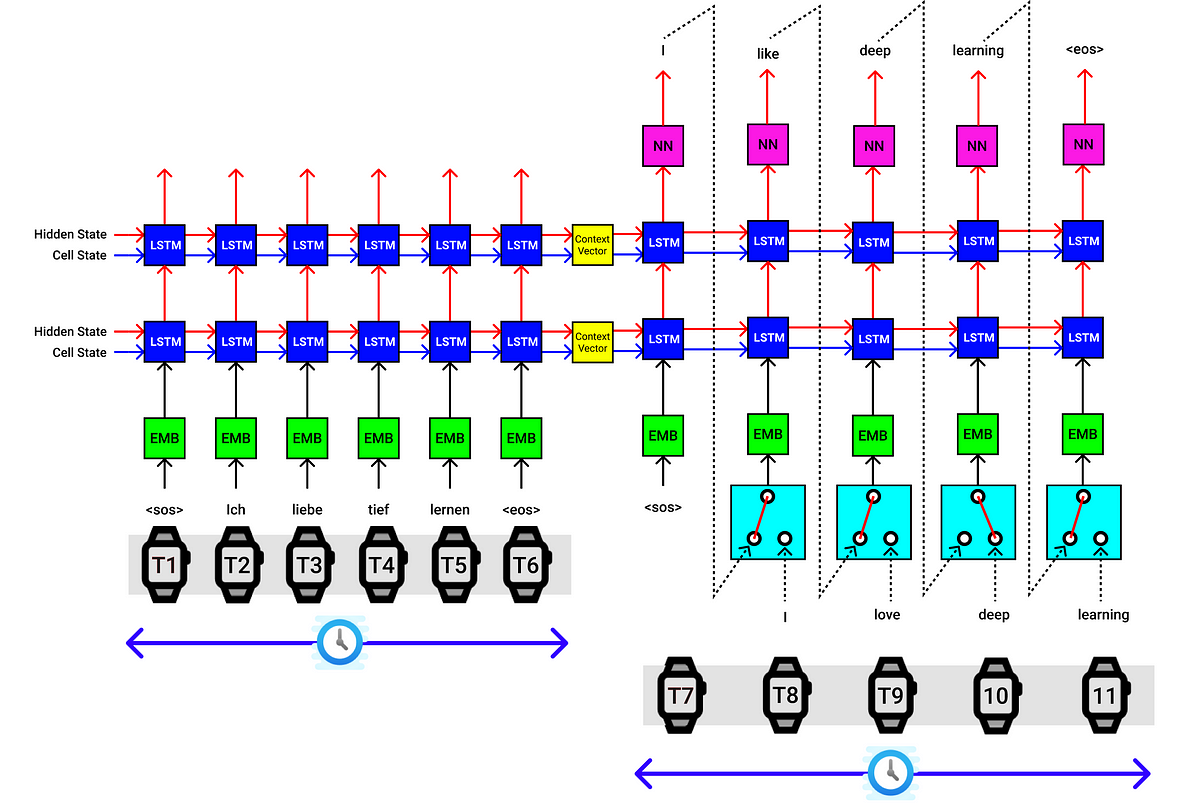

최종 seq2seq 구현은 위의 그림과 같습니다.
1. 입력(독일어)과 출력(영어) 문장을 모두 제공합니다.
2. 입력 시퀀스를 인코더에 전달하고 컨텍스트 벡터를 추출합니다.
3. 출력 시퀀스를 디코더에 전달하고, 인코더에서 컨텍스트 벡터를 추출하여 예측된 출력 시퀀스를 생성합니다.

In [20]:
class Seq2Seq(nn.Module):
  def __init__(self, Encoder_LSTM, Decoder_LSTM):
    super(Seq2Seq, self).__init__()
    self.Encoder_LSTM = Encoder_LSTM
    self.Decoder_LSTM = Decoder_LSTM

  def forward(self, source, target, tfr=0.5):  # tfr: Teacher Forcing Ratio
    # 소스의 형태: (10, 32) [독일어 문장 길이 + 패딩, 배치 크기]
    batch_size = source.shape[1]

    # 타겟의 형태: (14, 32) [영어 문장 길이 + 패딩, 배치 크기]
    target_len = target.shape[0]
    target_vocab_size = len(english.vocab)  # 영어 어휘 크기

    # 결과를 저장할 텐서 초기화: (14, 32, 5766) [영어 문장 길이, 배치 크기, 영어 어휘 크기]
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

    # 인코더의 결과 hidden_state와 cell_state를 얻음 (컨텍스트 벡터)
    # hidden_state와 cell_state의 형태: 각각 (2, 32, 1024) [레이어 수, 배치 크기, hidden state 차원]
    hidden_state, cell_state = self.Encoder_LSTM(source)

    # 초기 입력 토큰: <SOS> (Start of Sentence)
    # x의 형태: (32) [배치 크기]
    x = target[0]

    for i in range(1, target_len):
      # 디코더를 통해 출력 계산
      # output의 형태: (32, 5766) [배치 크기, 영어 어휘 크기]
      output, hidden_state, cell_state = self.Decoder_LSTM(x, hidden_state, cell_state)

      # 각 타임스텝의 출력 결과 저장
      outputs[i] = output

      # 출력 중 가장 확률이 높은 단어를 선택
      best_guess = output.argmax(1)  # 0번째 차원은 배치 크기, 1번째 차원은 단어 임베딩

      # Teacher Forcing Ratio에 따라 실제 타겟 단어를 사용할지, 모델의 예측 단어를 사용할지 결정
      x = target[i] if random.random() < tfr else best_guess

    # 최종 출력 형태: (14, 32, 5766) [영어 문장 길이, 배치 크기, 영어 어휘 크기]
    return outputs

### 7. 모델 학습

In [21]:
# Hyperparameters

learning_rate = 0.0005
writer = SummaryWriter(f"runs/loss_plot")
step = 0

seq2seq_model = Seq2Seq(encoder_lstm, decoder_lstm).to(device)
optimizer = optim.Adam(seq2seq_model.parameters(), lr=learning_rate)

pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [22]:
seq2seq_model

Seq2Seq(
  (Encoder_LSTM): EncoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(5374, 300)
    (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
  )
  (Decoder_LSTM): DecoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(4556, 300)
    (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=1024, out_features=4556, bias=True)
  )
)

In [23]:
def translate_sentence(model, sentence, german, english, device, max_length=50):
    # SpaCy를 이용하여 독일어 토크나이저 불러오기
    spacy_ger = spacy.load("de_core_news_sm")

    # 입력 문장이 문자열인 경우
    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:  # 입력 문장이 리스트인 경우
        tokens = [token.lower() for token in sentence]
    tokens.insert(0, german.init_token)  # 시작 토큰 추가
    tokens.append(german.eos_token)  # 종료 토큰 추가

    # 토큰을 인덱스로 변환
    text_to_indices = [german.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # 인코더에서 hidden state와 cell state 초기화
    with torch.no_grad():
        hidden, cell = model.Encoder_LSTM(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]  # 디코더 시작 토큰 설정

    # 최대 길이만큼 반복하며 디코더를 사용해 번역 생성
    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)  # 이전 단어 가져오기

        with torch.no_grad():
            # 디코더 실행
            output, hidden, cell = model.Decoder_LSTM(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()  # 확률이 가장 높은 단어 선택

        outputs.append(best_guess)

        # 종료 토큰을 예측한 경우 반복 종료
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    # 예측된 인덱스를 단어로 변환
    translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    return translated_sentence[1:]  # 시작 토큰 제외 후 반환


def bleu(data, model, german, english, device):
    # BLEU 점수 계산을 위한 대상 문장과 예측 문장 저장
    targets = []
    outputs = []

    # 데이터셋의 각 예제를 순회
    for example in data:
        src = vars(example)["src"]  # 원본 문장 가져오기
        trg = vars(example)["trg"]  # 대상 문장 가져오기

        # 번역 생성
        prediction = translate_sentence(model, src, german, english, device)
        prediction = prediction[:-1]  # 종료 토큰 제거

        targets.append([trg])  # 대상 문장 추가
        outputs.append(prediction)  # 예측 문장 추가

    # BLEU 점수 반환
    return bleu_score(outputs, targets)


def checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss):
    # 체크포인트 저장
    print('saving')
    print()

    # 모델 상태 저장
    state = {
        'model': model,  # 모델 객체
        'best_loss': best_loss,  # 최적 손실 값
        'epoch': epoch,  # 현재 에포크
        'rng_state': torch.get_rng_state(),  # 랜덤 시드 상태
        'optimizer': optimizer.state_dict(),  # 옵티마이저 상태
    }

    # 체크포인트 파일 저장
    torch.save(state, '/content/checkpoint-NMT')
    torch.save(model.state_dict(), '/content/checkpoint-NMT-SD')

In [24]:
# 초기 변수 설정
epoch_loss = 0.0  # 에포크별 손실 초기화
num_epochs = 100  # 총 학습 에포크 수
best_loss = 999999  # 초기 최적 손실 값 설정
best_epoch = -1  # 최적 에포크 초기화
sentence1 = "ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster"  # 테스트 문장
ts1 = []  # 번역 결과 저장 리스트

# 학습 반복 시작
for epoch in range(num_epochs):
    print("Epoch - {} / {}".format(epoch+1, num_epochs))  # 현재 에포크 출력
    epoch_loss = 0

    seq2seq_model.eval()  # 모델 평가 모드 설정
    translated_sentence1 = translate_sentence(seq2seq_model, sentence1, german, english, device, max_length=50)  # 테스트 문장 번역
    print(f"Translated example sentence 1: \n {translated_sentence1}")  # 번역 결과 출력
    ts1.append(translated_sentence1)  # 번역 결과 저장

    seq2seq_model.train()  # 모델 학습 모드 설정
    for batch_idx, batch in enumerate(train_iterator):
        input = batch.src.to(device)  # 입력 데이터를 GPU로 이동
        target = batch.trg.to(device)  # 타겟 데이터를 GPU로 이동

        # 모델의 forward 메서드에 입력과 타겟 전달
        output = seq2seq_model(input, target)
        output = output[1:].reshape(-1, output.shape[2])  # <sos> 토큰 제외 및 모양 변환
        target = target[1:].reshape(-1)  # <sos> 토큰 제외 및 모양 변환

        # 누적된 그래디언트 초기화
        optimizer.zero_grad()

        # 손실 값 계산
        loss = criterion(output, target)

        # 역전파를 통해 그래디언트 계산
        loss.backward()

        # 그래디언트가 특정 값을 초과하지 않도록 클리핑
        torch.nn.utils.clip_grad_norm_(seq2seq_model.parameters(), max_norm=3)

        # 그래디언트를 이용하여 가중치 업데이트
        optimizer.step()
        step += 1  # 글로벌 스텝 증가
        epoch_loss += loss.item() / len(train_iterator)  # 손실 값을 누적
        writer.add_scalar("Training loss", loss, global_step=step)  # TensorBoard에 손실 값 기록

    # 최적 손실 값 갱신 및 체크포인트 저장
    if epoch_loss < best_loss:
        best_loss = epoch_loss  # 최적 손실 갱신
        best_epoch = epoch  # 최적 에포크 갱신
        checkpoint_and_save(seq2seq_model, best_loss, epoch, optimizer, epoch_loss)  # 모델 저장

    # 최적 손실 이후 10 에포크 동안 개선 없으면 중단
    if ((epoch - best_epoch) >= 10):
        print("no improvement in 10 epochs, break")  # 개선 없음을 출력
        break

    print("Epoch_Loss - {}".format(epoch_loss))  # 에포크 손실 출력
    print()

# 학습 종료 후 평균 손실 출력
print(epoch_loss / len(train_iterator))

# BLEU 점수 계산
score = bleu(test_data[1:100], seq2seq_model, german, english, device)  # 테스트 데이터로 BLEU 점수 계산
print(f"Bleu score {score*100:.2f}")  # BLEU 점수 출력

Epoch - 1 / 100


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Translated example sentence 1: 
 ['torches', 'brick', 'elephants', 'raise', 'lemons', 'raise', 'lemons', 'wonder', 'installing', 'installing', 'installing', 'held', 'held', 'held', 'held', 'bead', 'bead', 'sari', 'build', 'bead', 'newspapers', 'toward', 'toward', 'held', 'held', 'devices', 'guns', 'torn', 'writing', 'beams', 'underway', 'beams', 'hikes', 'beams', 'nap', 'painting', 'painting', 'painting', 'moment', 'moment', 'vendors', 'moment', 'fort', 'cowboys', 'beanie', 'walkway', 'plates', 'toyota', 'board', 'board']
saving

Epoch_Loss - 4.432389961187998

Epoch - 2 / 100
Translated example sentence 1: 
 ['a', 'man', 'in', 'a', 'white', 'shirt', 'is', 'a', 'a', 'a', 'a', 'a', 'a', '.', '<eos>']
saving

Epoch_Loss - 3.705366849373561

Epoch - 3 / 100
Translated example sentence 1: 
 ['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'bench', '.', '<eos>']
saving

Epoch_Loss - 3.35257954345123

Epoch - 4 / 100
Translated example sentence 1: 
 ['a', 'man', 'in', 'a

### 8. 기계번역 수행

In [27]:
progress  = []
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
for i, sen in enumerate(ts1):
  progress.append(TreebankWordDetokenizer().detokenize(sen))
print(progress)

['torches brick elephants raise lemons raise lemons wonder installing installing installing held held held held bead bead sari build bead newspapers toward toward held held devices guns torn writing beams underway beams hikes beams nap painting painting painting moment moment vendors moment fort cowboys beanie walkway plates toyota board board', 'a man in a white shirt is a a a a a a . <eos>', 'a man in a blue shirt is standing on a bench . <eos>', 'a man in a blue shirt is standing on a sidewalk . <eos>', 'a man in a blue shirt is on a bench while a a . <eos>', 'a man in a blue shirt is standing on a ladder . <eos>', 'a man in a blue shirt is standing on a ladder of a . <eos>', 'a man in a blue shirt is standing a ladder painting a wall . <eos>', 'a man in a blue shirt standing on a ladder painting a a . <eos>', 'a man in a blue shirt standing on a ladder cleaning a a . <eos>', 'a man in a blue shirt is standing on a ladder painting a a . <eos>', 'a man in a blue shirt is standing on 

In [28]:
seq2seq_model.eval()
test_sentences  = ["Zwei Männer gehen die Straße entlang", "Kinder spielen im Park.", "Diese Stadt verdient eine bessere Klasse von Verbrechern. Der Spaßvogel"]
actual_sentences  = ["Two men are walking down the street", "Children play in the park", "This city deserves a better class of criminals. The joker"]
pred_sentences = []

for idx, i in enumerate(test_sentences):
  seq2seq_model.eval()
  translated_sentence = translate_sentence(seq2seq_model, i, german, english, device, max_length=50)
  progress.append(TreebankWordDetokenizer().detokenize(translated_sentence))
  print("German : {}".format(i))
  print("Actual Sentence in English : {}".format(actual_sentences[idx]))
  print("Predicted Sentence in English : {}".format(progress[-1]))
  print()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


German : Zwei Männer gehen die Straße entlang
Actual Sentence in English : Two men are walking down the street
Predicted Sentence in English : two men are walking down the street . <eos>

German : Kinder spielen im Park.
Actual Sentence in English : Children play in the park
Predicted Sentence in English : kids playing ball in the park . <eos>

German : Diese Stadt verdient eine bessere Klasse von Verbrechern. Der Spaßvogel
Actual Sentence in English : This city deserves a better class of criminals. The joker
Predicted Sentence in English : this <unk> be a <unk> <unk> <unk> <unk> <unk>. <eos>



## BLEU Score (기계번역 평가)

In [29]:
import numpy as np
from collections import Counter
from nltk import ngrams

In [30]:
# 토큰화 된 문장(tokens)에서 n-gram을 카운트
def simple_count(tokens, n):
  return Counter(ngrams(tokens, n))

In [31]:
candidate = "It is a guide to action which ensures that the military always obeys the commands of the party."
tokens = candidate.split() # 토큰화
result = simple_count(tokens, 1) # n = 1은 유니그램
print('유니그램 카운트 :',result)

유니그램 카운트 : Counter({('the',): 3, ('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('which',): 1, ('ensures',): 1, ('that',): 1, ('military',): 1, ('always',): 1, ('obeys',): 1, ('commands',): 1, ('of',): 1, ('party.',): 1})


In [32]:
candidate = 'the the the the the the the'
tokens = candidate.split() # 토큰화
result = simple_count(tokens, 1) # n = 1은 유니그램
print('유니그램 카운트 :',result)

유니그램 카운트 : Counter({('the',): 7})


In [33]:
def count_clip(candidate, reference_list, n):
  # Ca 문장에서 n-gram 카운트
  ca_cnt = simple_count(candidate, n)
  max_ref_cnt_dict = dict()

  for ref in reference_list:
    # Ref 문장에서 n-gram 카운트
    ref_cnt = simple_count(ref, n)

    # 각 Ref 문장에 대해서 비교하여 n-gram의 최대 등장 횟수를 계산.
    for n_gram in ref_cnt:
      if n_gram in max_ref_cnt_dict:
        max_ref_cnt_dict[n_gram] = max(ref_cnt[n_gram], max_ref_cnt_dict[n_gram])
      else:
        max_ref_cnt_dict[n_gram] = ref_cnt[n_gram]

  return {
        # count_clip = min(count, max_ref_count)
        n_gram: min(ca_cnt.get(n_gram, 0), max_ref_cnt_dict.get(n_gram, 0)) for n_gram in ca_cnt
     }

In [34]:
candidate = 'the the the the the the the'
references = [
    'the cat is on the mat',
    'there is a cat on the mat'
]
result = count_clip(candidate.split(),list(map(lambda ref: ref.split(), references)),1)
print('유니그램 카운트 :',result)

유니그램 카운트 : {('the',): 2}


In [35]:
def modified_precision(candidate, reference_list, n):
  clip_cnt = count_clip(candidate, reference_list, n)
  total_clip_cnt = sum(clip_cnt.values()) # 분자

  cnt = simple_count(candidate, n)
  total_cnt = sum(cnt.values()) # 분모

  # 분모가 0이 되는 것을 방지
  if total_cnt == 0:
    total_cnt = 1

  # 분자 : count_clip의 합, 분모 : 단순 count의 합 ==> 보정된 정밀도
  return (total_clip_cnt / total_cnt)

In [36]:
result = modified_precision(candidate.split(), list(map(lambda ref: ref.split(), references)), n=1)
print('보정된 유니그램 정밀도 :',result)

보정된 유니그램 정밀도 : 0.2857142857142857


In [37]:
# Ca 길이와 가장 근접한 Ref의 길이를 리턴하는 함수
def closest_ref_length(candidate, reference_list):
  ca_len = len(candidate) # ca 길이
  ref_lens = (len(ref) for ref in reference_list) # Ref들의 길이
  # 길이 차이를 최소화하는 Ref를 찾아서 Ref의 길이를 리턴
  closest_ref_len = min(ref_lens, key=lambda ref_len: (abs(ref_len - ca_len), ref_len))
  return closest_ref_len

In [38]:
def brevity_penalty(candidate, reference_list):
  ca_len = len(candidate)
  ref_len = closest_ref_length(candidate, reference_list)

  if ca_len > ref_len:
    return 1

  # candidate가 비어있다면 BP = 0 → BLEU = 0.0
  elif ca_len == 0 :
    return 0
  else:
    return np.exp(1 - ref_len/ca_len)

In [39]:
def bleu_score(candidate, reference_list, weights=[0.25, 0.25, 0.25, 0.25]):
  bp = brevity_penalty(candidate, reference_list) # 브레버티 패널티, BP

  p_n = [modified_precision(candidate, reference_list, n=n) for n, _ in enumerate(weights,start=1)]
  # p1, p2, p3, ..., pn
  score = np.sum([w_i * np.log(p_i) if p_i != 0 else 0 for w_i, p_i in zip(weights, p_n)])
  return bp * np.exp(score)

In [40]:
import nltk.translate.bleu_score as bleu

candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

print('실습 코드의 BLEU :',bleu_score(candidate.split(),list(map(lambda ref: ref.split(), references))))
print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))

실습 코드의 BLEU : 0.5045666840058485
패키지 NLTK의 BLEU : 0.5045666840058485


## (Appendix) Image Captioning

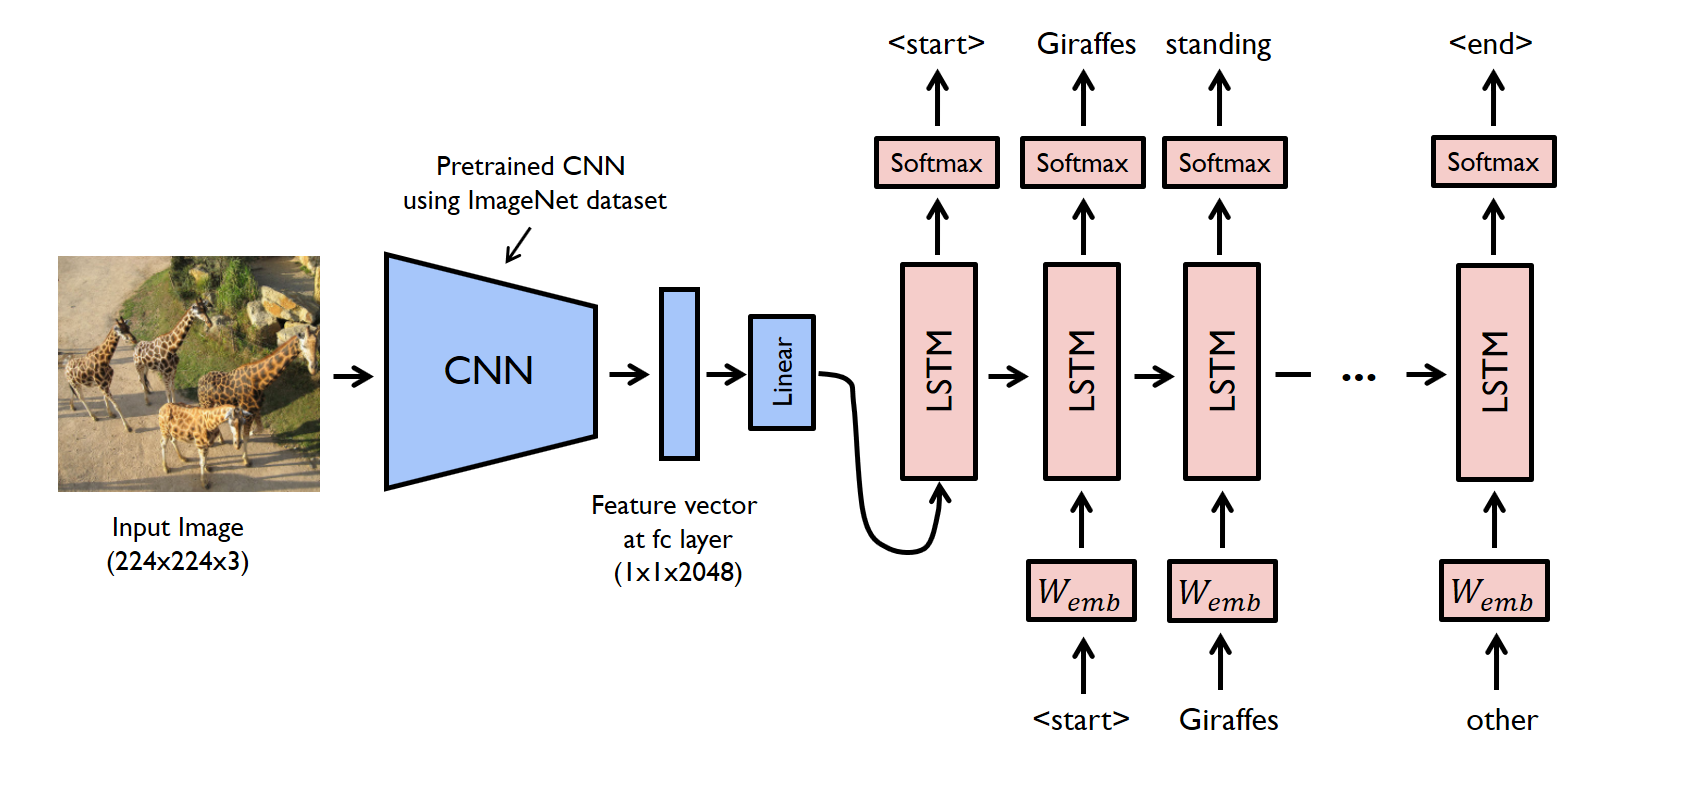

In [41]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt

In [42]:
from PIL import Image
import requests
from io import BytesIO

url = "https://huggingface.co/datasets/mishig/sample_images/resolve/main/airport.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

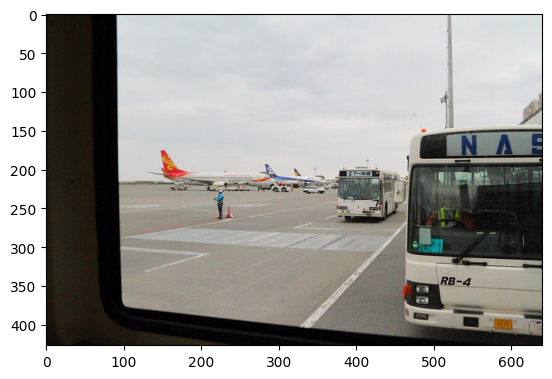

In [43]:
plt.imshow(img)
plt.show()

In [44]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    response = requests.get(image_path)
    i_image = Image.open(BytesIO(response.content))
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  print(preds)

predict_step(['https://huggingface.co/datasets/mishig/sample_images/resolve/main/airport.jpg'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


['airplanes parked on the tarmac at an airport']


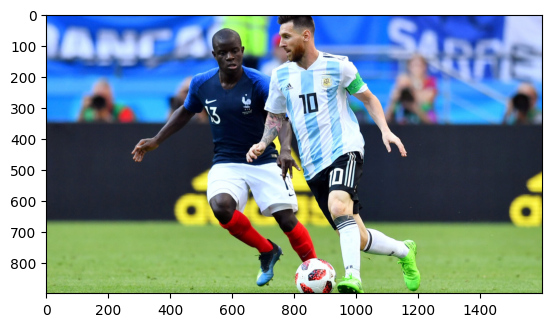

['a soccer player kicking a soccer ball on a field']


In [45]:
url = "https://static01.nyt.com/images/2020/09/25/sports/25soccer-nationalWEB1/merlin_177451008_91c7b66d-3c8a-4963-896e-54280f374b6d-videoSixteenByNineJumbo1600.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.show()

predict_step([url])

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

[{'generated_text': 'two soccer players are playing soccer on a field '}]


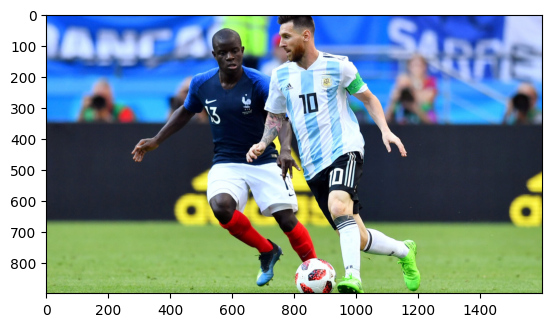

In [46]:
from transformers import pipeline

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

url = "https://static01.nyt.com/images/2020/09/25/sports/25soccer-nationalWEB1/merlin_177451008_91c7b66d-3c8a-4963-896e-54280f374b6d-videoSixteenByNineJumbo1600.jpg"

results = image_to_text(url)
print(results)
response = requests.get(url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.show()